## Estimating predictive power of models for each data point

If we use all the available data (barring one point) to predict the observation at
that point, we can estimate how effective our model is likely to be at estimating
the moho depth in the region of this observation.

We take the range of model parameters we use in the general fitting process and
we compute the statistics of the fit each individual point. Note - this requires 
that we re-fit the data with one point removed. We do not, in this case, repeat the
process of adaptively fitting the data to the points in this case as we are not
attempting to determine the effectiveness of the procedure for applications to 
other collections of observations. 

We assume uniform weights for all data points in this procedure as we have no
better information about them at this stage. 


In [1]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import litho1pt0

import gdal

In [2]:
## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, refinement_levels=4, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

grid1 = stripy.sTriangulation(grid1r.lons_map_to_wrapped(grid1r.lons[nodes])%(2.0*np.pi), grid1r.lats[nodes], permute=True)


# grid2r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, refinement_levels=5, tree=True)

# ## Drop points outside the region of interest

# angles = grid2r.angular_separation( grid2r.lons, grid2r.lats, np.radians(-158.0) * np.ones_like(grid2r.lons), 
#                                    np.radians(62.0) * np.ones_like(grid2r.lats) ) 

# nodes = np.where(angles < np.radians(20.0))

# grid2 = stripy.sTriangulation(grid2r.lons_map_to_wrapped(grid2r.lons[nodes])%(2.0*np.pi), grid2r.lats[nodes], permute=True)


In [3]:
## Assuming the previous notebook was run, read in the data ...

Moho_data_filename="AlaskaMoLo"
data = np.load("Models/{}.npz".format(Moho_data_filename))
moho_data_all = data['alaska_moho']

datagrid = stripy.sTriangulation(np.radians(moho_data_all['lon']),
                                 np.radians(moho_data_all['lat']), 
                                 permute=True, tree=False)


## Build several triangulations for testing

Let $p_1$ be the free parameter (the target nodal weight) for the mesh and obtain meshes for a range of values of this parameter 


In [4]:
targets_p1 = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13, 15, 20, 30]
targets_p2 = [0.01,0.05, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


targets_p1 = [100, 125, 150, 175, 200, 225, 250]
targets_p2 = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0, 15.0]

In [5]:
def weighted_average_to_nodes(lons, lats, data, interpolator ):

    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!

    for i in range(0, len(data)):

        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        

    grid[np.where(norm > 0.0)] /= norm[np.where(norm > 0.0)]
    
    return grid, norm, count

def refine_grid_to_target_points_1(lons, lats, grid1, target_value ):

    grids = [grid1]
    

    target = target_value

    for i in range(0, 20):

        ## First refine

        ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grids[-1])

        node_area = np.zeros(grids[-1].npoints)
        t_areas = grids[-1].areas()

        for t,simplex in enumerate(grids[-1].simplices):
            node_area[simplex] += t_areas[t] 

        node_area /= node_area.max()

        ## Conditions on weighted average & min area 
        
        vertices = np.where(np.logical_and(norm > target, node_area > 0.0001))[0]

        if vertices.shape[0] != 0: 
            newlons, newlats = grids[-1].centroid_refine_triangulation_by_vertices(vertices=vertices)
            rgrid = stripy.sTriangulation(newlons, newlats, permute=False)
            grids.append(rgrid)

        else:        
            break

    # Needs a final update 
    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grids[-1])
    return grids[-1], norm


## Build grids for each target p1 value

def refine_grid_to_target_points(lons, lats, target_value ):
       
    from scipy.cluster.vq import kmeans, kmeans2, whiten
    
    xyz = np.array(stripy.spherical.lonlat2xyz(np.radians(lons), np.radians(lats))).T   
    xyzk,k = kmeans2(xyz, target_value, minit="random")
    xyzk_norm = xyzk / np.sqrt((xyzk**2).sum(axis=1)).reshape(-1,1)
    newlons, newlats = stripy.spherical.xyz2lonlat(xyzk_norm[:,0], xyzk_norm[:,1], xyzk_norm[:,2])
    
    grid = stripy.sTriangulation(lons=newlons, lats=newlats, permute=True, tree=True)
    
    # Needs a final update 
    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grid)
    return grid, norm


## Build MANY grids for each target p1 value (20 or more)

grid_realisations = 10
grid_ensemble=[]
norms_ensemble=[]

for i in range(0, grid_realisations):
    
    print i
    
    adapted_grids = {}
    grid_norm = {}

    ## Poor clustering produces "NaN" in grid_norm ... repeat until it works !!! 

    for p1 in targets_p1:
        success = False
        count = 0
        while not success:
            count += 1
            if count%10 ==0:
                print("Still attempting to find a good grid for p1 = {} after {} tries".format(p1, count))
            adapted_grids[p1], grid_norm[p1] = refine_grid_to_target_points(moho_data_all['lon'], moho_data_all['lat'], p1)
            if not np.isnan(grid_norm[p1].min()):
                try:
                    adapted_grids[p1].smoothing(np.random.rand(p1), np.ones(p1), 1.0, 0.5, 0.1)
                    success = True
                    print("{} attempts required to obtain a reasonable grid for p1 = {}".format(count, p1))
                except:
                    success = False

        grid_ensemble.append(adapted_grids)
        norms_ensemble.append(grid_norm)

0
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
2 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
2 attempts required to obtain a reasonable grid for p1 = 250
1
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
2
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts require

/usr/local/lib/python2.7/site-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python2.7/site-packages/stripy/spherical.py:694: RuntimeWarning: invalid value encountered in divide
  bcc /= bcc.sum(axis=1).reshape(-1,1)
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


1 attempts required to obtain a reasonable grid for p1 = 125
2 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
2 attempts required to obtain a reasonable grid for p1 = 225
2 attempts required to obtain a reasonable grid for p1 = 250
4
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required to obtain a reasonable grid for p1 = 175
1 attempts required to obtain a reasonable grid for p1 = 200
1 attempts required to obtain a reasonable grid for p1 = 225
1 attempts required to obtain a reasonable grid for p1 = 250
5
1 attempts required to obtain a reasonable grid for p1 = 100
1 attempts required to obtain a reasonable grid for p1 = 125
1 attempts required to obtain a reasonable grid for p1 = 150
1 attempts required 

In [6]:
## This is a smoothed version of the gridded data - the smoothing operator is taken from ssrfpack 
## The weights indicate the confidence in the data. For points that have few constraints, the weight 
## might well be lower but, perhaps, the variance should also play a role ... 

def compute_smoothed_solutions(goodgrid, gnorm, weight, data, a1):

    ## We down-weight values where there is a very small contribution from the
    ## data, but we don't up-weight when multiple points contribute since we
    ## don't know if they are all consistent
    
    weights = 0.01 + weight * np.minimum(gnorm,1.0) #  / gnorm.max()
    ave = data

    smooth_d = goodgrid.smoothing(ave, weights, a1*goodgrid.npoints, 0.5, 0.0001)

    return smooth_d

In [7]:
def partition_data_node(moho_data_all, node):
    
    test = (np.arange(0,moho_data_all.shape[0],1) == node)
    training = ~test

    moho_data = moho_data_all[training]
    moho_data_test = moho_data_all[test]

    return moho_data, moho_data_test


In [8]:
def data_model_minus_one(e, p1, p2, moho_data_all, node):
    """
    p1 -> target parameter in adaptive triangulation
    p2 -> smoothing parameter (should be a list / array as this does not require re-triangulation)
    moho_data has one point removed
    """
    
    moho_data, moho_data_test = partition_data_node(moho_data_all, node)
    
    import litho1pt0
    
    grid = grid_ensemble[e][p1]
 
    ## This information changes when the data is subsampled - only local to 
    ## this missing node, but this is not time-critical for a small dataset
    
    ave, gnorm, count = weighted_average_to_nodes(np.radians(moho_data['lon']), 
                                                  np.radians(moho_data['lat']), 
                                                  moho_data['moh'], grid)

    ## If we have no information for a location in the grid for this partitioning of the
    ## data, then we fill from litho 1.0 - the weight associated with these points
    ## is low and should not influence the surrounding values

    unconstrained_locations = np.where(gnorm < 1.0e-5)[0]
        
    if unconstrained_locations.shape[0] != 0:
        unknown_lons_deg = np.degrees(grid.lons[unconstrained_locations])%360.0
        unknown_lats_deg = np.degrees(grid.lats[unconstrained_locations])
    
        c2 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="LID-TOP")
        c1 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="CRUST1-TOP")

        ave[unconstrained_locations] = (c2-c1) * 0.001 ## Convert to km

    
    ## The smoothing requires solving a least-squares problems and this may
    ## Not converge. If so, we still need something to for the computation
    ## but we will return an error flag too. 
    
    try:
        predictor, deriv = compute_smoothed_solutions(grid, gnorm, 1.0, ave, p2)
        failed = 0
    except:
#         print("Cannot compute accurate smooth solution for p1 = {}, p2 = {}".format(p1, p2))
#         predictor, deriv = compute_smoothed_solutions(grid, enorm, 0.1, ave, 0.01)
#         failed = 1
        
        print("Cannot compute accurate smooth solution for p1 = {}, p2 = {}".format(p1, p2))
        predictor = np.zeros(grid.npoints)
        deriv = np.zeros((grid.npoints,3))
        failed = 1



    
    ## This is a measure of how well the model fits the test data point
    
    smooth_data_prediction, e0 = grid.interpolate(np.radians(moho_data_test['lon']),
                                                   np.radians(moho_data_test['lat']), 
                                                   predictor, order=3) 
    
    err = (smooth_data_prediction - moho_data_test['moh'])
    
        
    ## This is a measure of how well the model agrees with the points that it fits
    

    smooth_data_reconstruction, e0 = grid.interpolate(np.radians(moho_data['lon']),
                                                        np.radians(moho_data['lat']), predictor, order=3)
    
    err1 = np.sqrt(((smooth_data_reconstruction - moho_data['moh'])**2).sum() / moho_data.shape[0])


    return err, err1, err / err1, predictor



In [9]:

## Make a partitioning of the data, then multiple triangulations / smoother settings

nodes = moho_data_all.shape[0]

## Find the best p1, p2 for each bisection of the data

targets_p2 = [0.01, 0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

err1 = np.zeros((nodes, grid_realisations, len(targets_p1), len(targets_p2)))
err2 = np.zeros((nodes, grid_realisations, len(targets_p1), len(targets_p2)))
errR = np.zeros((nodes, grid_realisations, len(targets_p1), len(targets_p2)))

for n in range(0,nodes):
    print "Node no ", n
    moho_data, moho_data_test = partition_data_node(moho_data_all, n)

    for e in range(0, grid_realisations):
        for i, target_p1 in enumerate(targets_p1):
            for j, target_p2 in enumerate(targets_p2):

                e1, e2, eR, predictor = data_model_minus_one(e, target_p1, target_p2, moho_data_all, n)
                err1[n,e,i,j] = e1
                err2[n,e,i,j] = e2
                errR[n,e,i,j] = eR



Node no  0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  3
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth so

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  11
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  14
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Node no  22
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  28
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  36
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  39
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  47
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 8.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 8.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1

Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  52
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  55
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  66
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  69
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  80
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  83
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  94
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  97
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  108
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  111
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  122
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  125
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  128
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  139
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  150
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Node no  158
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  161
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  175
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Node no  183
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  186
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  197
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  208
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  211
Cannot compute accurate smooth

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  222
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth s

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  225
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  228
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  239
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  261
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  272
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  283
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  286
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  294
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  297
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  308
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  319
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  322
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution fo

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  336
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth 

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Node no  339
Cannot compute accurate smooth

Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 125, p2 = 10.0
Cannot compute accurate smooth solution for

Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 250, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 9.0
Cannot compute accurate smooth solution for p1 = 100, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 150, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 200, p2 = 10.0
Cannot compute accurate smooth solution for p1 = 225, p2 = 10.0
Cannot compute accurate smooth solution fo

In [10]:
## Data reduction ... 

data_pt_mean = np.empty_like(moho_data_all['moh'])
data_pt_min  = np.empty_like(moho_data_all['moh'])
data_pt_var  = np.empty_like(moho_data_all['moh'])

for e in range(0,len(moho_data_all)):
    errE = err1[e]
    errE2 = err2[e]
    
    data_pt_min[e]  = np.abs(errE).min()
    data_pt_mean[e] = errE.mean()
    data_pt_var[e]  = np.sqrt(((errE - data_pt_mean[e])**2).mean())


In [22]:
## Model scoring - which data points should be respected:
##
## - those with low variance, low mean error should be favoured  
## - those with small minimum error are capable of constraining models regardless of the variance
## - high (min or mean) error + large variance are not fit by any of these models

score1 = np.zeros(moho_data_all.shape)

score1[np.where(data_pt_min < data_pt_min.mean())] += 1.0

score2 = np.zeros(moho_data_all.shape)
score2[np.logical_and(np.abs(data_pt_mean/moho_data_all['moh']) < 0.25, data_pt_var < data_pt_var.mean())] = 1.0

score = 0.1 + score1 + score2

In [23]:
# moho_data_plus = moho_data_all.copy()
# moho_data_plus['mean_err']  = data_pt_mean
# moho_data_plus['min_err'] = data_pt_min
# moho_data_plus['variance'] = data_pt_var
# moho_data_plus['q_score'] = score

In [24]:
## Save this variance estimate to datafile

from numpy.lib.recfunctions import append_fields

moho_data_plus = append_fields(moho_data_all, names=["min_err", "mean_err", "variance", "q_score"], 
                               data=[data_pt_min, data_pt_mean, data_pt_var, score], 
                               dtypes=[np.float, np.float, np.float, np.float])

In [25]:
np.savez("Models/{}Errs.npz".format(Moho_data_filename), alaska_moho=moho_data_plus)


In [26]:
for e in range(0,len(moho_data_all)):
    print "{} : {:8.3f}  {:8.3f}  {:8.3f}  {:8.3f}".format(e, 
                                                       data_pt_min[e], 
                                                       data_pt_mean[e], 
                                                       data_pt_var[e],
                                                       moho_data_plus['moh'][e])

0 :    0.009    -5.994    15.773    42.436
1 :    0.070     0.115     9.437    33.324
2 :    0.005     2.260     8.539    29.235
3 :    0.085    14.690    10.206    19.655
4 :    0.094     7.652     9.251    25.964
5 :    0.036    -0.305     8.241    32.856
6 :    0.023    -5.429     8.108    37.296
7 :    1.076    -8.829     8.038    40.450
8 :    0.061    -2.878     8.029    34.609
9 :    0.038    -0.157     7.778    31.794
10 :    0.011    -4.186     7.684    34.084
11 :    1.237    -6.075     7.608    36.711
12 :    0.106    -3.717     7.683    34.426
13 :    0.379     0.190     7.768    30.987
14 :    0.152    -0.873     7.721    31.922
15 :    5.804    -9.901     6.872    40.099
16 :    0.006    -1.298     7.780    33.090
17 :    0.171   -14.676    11.149    53.779
18 :    0.050    -1.002     7.793    32.856
19 :    2.241     4.624     8.117    28.282
20 :    0.047     0.395     7.794    31.183
21 :    0.011    -2.515     7.836    34.542
22 :    0.076    -4.120     7.890    35.76

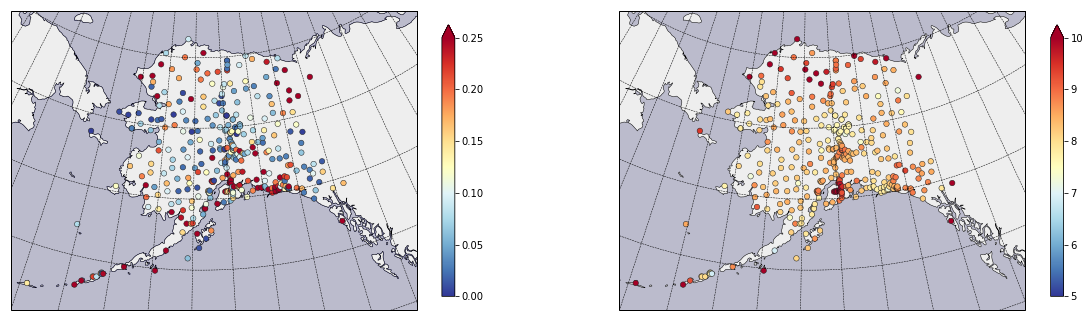

In [27]:

fig = plt.figure(figsize=(20, 10), facecolor="none")
ax1  = plt.subplot(121, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))



ax2  = plt.subplot(122, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))


ax1.set_extent([-175,-130,50,72])
ax2.set_extent([-175,-130,50,72])

# ax.set_global()

ax1.coastlines(resolution="50m",color="#000066", linewidth=0.5)


lons0 = np.degrees(datagrid.lons)
lats0 = np.degrees(datagrid.lats)
moho  = moho_data_plus['moh']
error = moho_data_plus['mean_err']
minerr = data_pt_min

grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m",
                                           name="graticules_5")

ocean = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="ocean")

land = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="land")



ax1.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=2)
ax1.add_feature(ocean, alpha=0.5, zorder=0, facecolor="#BBBBCC")
ax1.add_feature(land, alpha=1.0,  zorder=1, facecolor="#EEEEEE")

ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=3)



m = ax1.scatter(lons0, lats0, c=np.abs(error/moho), cmap=plt.cm.RdYlBu_r, 
                edgecolor="#222222", linewidth=0.5, vmin=0, vmax=0.25,
                marker="o", s=30.0, transform=ccrs.Geodetic(), zorder=3)

plt.colorbar(mappable=m, ax=ax1, shrink=0.5, extend='max' )

## 2nd one

ax2.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=2)
ax2.add_feature(ocean, alpha=0.5, zorder=0, facecolor="#BBBBCC")
ax2.add_feature(land, alpha=1.0,  zorder=1, facecolor="#EEEEEE")

ax2.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=3)
 
m = ax2.scatter(lons0, lats0, c=moho_data_plus['variance'], cmap=plt.cm.RdYlBu_r, 
                edgecolor="#222222", linewidth=0.5,  vmin=5, vmax=10,
                marker="o", s=30.0, transform=ccrs.Geodetic(), zorder=3)

plt.colorbar(mappable=m, ax=ax2, shrink=0.5, extend='max' )


fig.savefig("Images/{}-ModeledErrors.png".format(Moho_data_filename), dpi=300)

pass

In [28]:
moho_data_plus["variance"].mean()

8.520638118704884

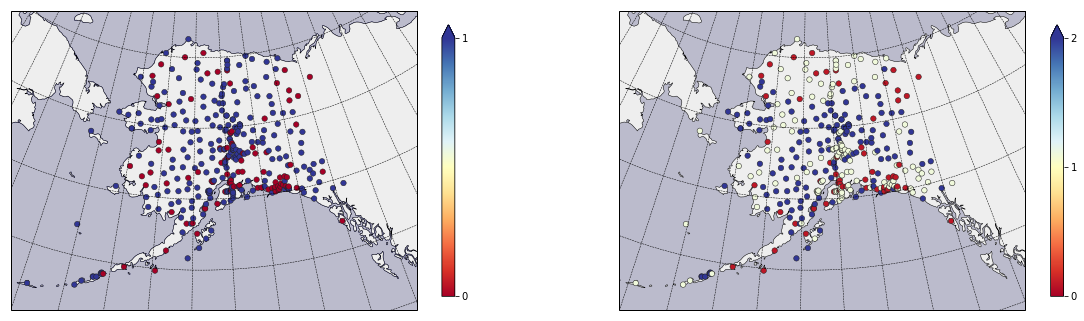

In [29]:

fig = plt.figure(figsize=(20, 10), facecolor="none")
ax1  = plt.subplot(121, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))



ax2  = plt.subplot(122, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))


ax1.set_extent([-175,-130,50,72])
ax2.set_extent([-175,-130,50,72])

# ax.set_global()

ax1.coastlines(resolution="50m",color="#000066", linewidth=0.5)


grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m",
                                           name="graticules_5")

ocean = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="ocean")

land = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="land")



ax1.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=2)
ax1.add_feature(ocean, alpha=0.5, zorder=0, facecolor="#BBBBCC")
ax1.add_feature(land, alpha=1.0,  zorder=1, facecolor="#EEEEEE")

ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=3)



m = ax1.scatter(lons0, lats0, c=score1, cmap=plt.cm.RdYlBu, 
                edgecolor="#222222", linewidth=0.5, vmin=0, vmax=1.0,
                marker="o", s=30.0, transform=ccrs.Geodetic(), zorder=3)

plt.colorbar(mappable=m, ax=ax1, shrink=0.5, extend='max', ticks=[0,1]  )


## 2nd one

ax2.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=2)
ax2.add_feature(ocean, alpha=0.5, zorder=0, facecolor="#BBBBCC")
ax2.add_feature(land, alpha=1.0,  zorder=1, facecolor="#EEEEEE")

ax2.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=3)
 
m = ax2.scatter(lons0, lats0, c=score, cmap=plt.cm.RdYlBu, 
                edgecolor="#222222", linewidth=0.5, vmin=0, vmax=2.0,
                marker="o", s=30.0, transform=ccrs.Geodetic(), zorder=3)

plt.colorbar(mappable=m, ax=ax2, shrink=0.5, extend='max', ticks=[0,1,2] )


fig.savefig("Images/{}-ModelScores.png".format(Moho_data_filename), dpi=300)



pass

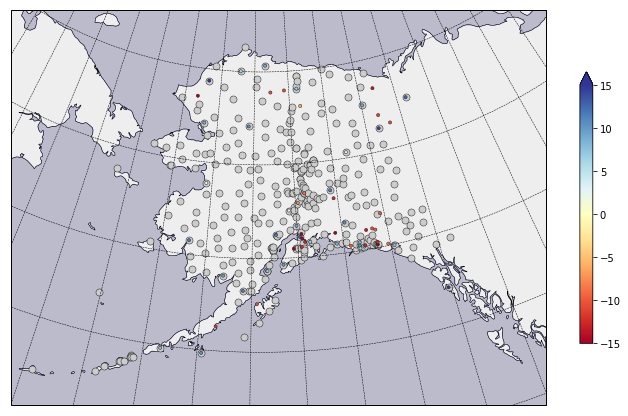

In [30]:
### Based on these scores, we can separate the outliers into significantly shallower and significantly deeper and consider
### fitting these sets of data independently (these are clustered in the region where the slab is flat under the continent)


## For those models which score zero, which ones are on the plus side and which on the minus side ?


fig = plt.figure(figsize=(12, 10), facecolor="none")
ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
ax1.set_extent([-175,-130,50,72])

# ax.set_global()

ax1.coastlines(resolution="50m",color="#000066", linewidth=0.5)


grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m",
                                           name="graticules_5")

ocean = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="ocean")

land = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="land")


ax1.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=2)
ax1.add_feature(ocean, alpha=0.5, zorder=0, facecolor="#BBBBCC")
ax1.add_feature(land, alpha=1.0,  zorder=1, facecolor="#EEEEEE")

shallow_outliers = np.logical_and(score < 0.5, error < 0.0)
deep_outliers    = np.logical_and(score < 0.5, error > 0.0)
inliers          = score >= 0.5
outliers         = score <  0.5

shallow_and_inliers = np.logical_or(shallow_outliers, inliers)
deep_and_inliers    = np.logical_or(deep_outliers, inliers)


ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=3)

m = ax1.scatter(moho_data_all['lon'][deep_and_inliers], moho_data_all['lat'][deep_and_inliers], 
                c="#CCCCCC", cmap=plt.cm.RdYlBu, 
                edgecolor="#222222", linewidth=0.5, vmin=0, vmax=2.0,
                marker="o", s=50.0, transform=ccrs.Geodetic(), zorder=3)

# m = ax1.scatter(moho_data_all['lon'][inliers], moho_data_all['lat'][inliers], 
#                 c="#CCCCCC", cmap=plt.cm.RdYlBu, 
#                 edgecolor="#222222", linewidth=0.5, vmin=0, vmax=2.0,
#                 marker="o", s=50.0, transform=ccrs.Geodetic(), zorder=3)

m = ax1.scatter(moho_data_all['lon'][outliers], moho_data_all['lat'][outliers], 
                c=error[outliers], cmap=plt.cm.RdYlBu, 
                edgecolor="#222222", linewidth=0.5, vmin=-15, vmax=15,
                marker="o", s=10.0, transform=ccrs.Geodetic(), zorder=4)


plt.colorbar(mappable=m, ax=ax1, shrink=0.5, extend='max', ticks=[-15,-10,-5, 0 ,5 , 10, 15] )
pass




In [31]:
## We can reprocess these files for double moho solutions but only write these files if 
## we were working with the original data

if(Moho_data_filename=="AlaskaMoho"):
    np.savez("Models/AlaskaMoHi.npz", alaska_moho=moho_data_all[shallow_and_inliers])
    np.savez("Models/AlaskaMoLo.npz", alaska_moho=moho_data_all[deep_and_inliers])
    